## Hierarchical Bayesian analysis of the 2019-2020 NHL season (until it got canceled)

---

I am sad and I miss hockey, so I decided to build a simple hierarchical Bayesian model for the 2019-2020 NHL season. Since this model is fully probabilistic, I will be able to assess the offensive and defensive ability of teams. Furthermore, I can draw samples from the posterior distribution to simulate entire seasons, and the post-season, to see who is the true Cup champ.

This work is based in large part on [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf), [Daniel Weitzenfeld's great write-up](https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/), and a [nice application of this type of modeling to Rugby from the pymc3 docs](https://docs.pymc.io/notebooks/rugby_analytics.html).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt

### Get the data

---

I will use pandas to scrape the 2019-2020 NHL season schedule and results from  [www.hockey-reference.com](https://www.hockey-reference.com/leagues/NHL_2020_games.html). Note that I will only get the results of every game played up to COVID-19 season suspension, but I will also have the schedule so I can simulate the rest of the season as well.

In [2]:
url = "http://www.hockey-reference.com/leagues/NHL_2020_games.html"
df = pd.read_html(url, parse_dates=True, attrs = {'id': 'games'},
                  header=0, index_col=0)[0]

In [3]:
df.head()

,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes
Date,,,,,,,,
2019-10-02,Vancouver Canucks,2.0,Edmonton Oilers,3.0,NaN,18347.0,2:23,NaN
2019-10-02,Washington Capitals,3.0,St. Louis Blues,2.0,OT,18096.0,2:32,NaN
2019-10-02,Ottawa Senators,3.0,Toronto Maple Leafs,5.0,NaN,19612.0,2:36,NaN
2019-10-02,San Jose Sharks,1.0,Vegas Golden Knights,4.0,NaN,18588.0,2:44,NaN
2019-10-03,Arizona Coyotes,1.0,Anaheim Ducks,2.0,NaN,17174.0,2:25,NaN


Looks like I have some data cleaning to do. For this modeling, we do not care about the attendance, length of the game (LOG), nor the Notes column, which is just empty. We can drop those. Also, since we are just building a model based on the raw game scores, I will drop the column that indicates if the game went to OT or a SO. 

In [4]:
df.drop(columns=["Unnamed: 5", "Att.", "LOG", "Notes"], inplace=True)

In [5]:
df.tail()

,Visitor,G,Home,G.1
Date,,,,
2020-04-04,Chicago Blackhawks,NaN,New York Rangers,NaN
2020-04-04,Pittsburgh Penguins,NaN,Ottawa Senators,NaN
2020-04-04,Anaheim Ducks,NaN,San Jose Sharks,NaN
2020-04-04,Montreal Canadiens,NaN,Toronto Maple Leafs,NaN
2020-04-04,Vegas Golden Knights,NaN,Vancouver Canucks,NaN


These games, sadly, have not been played, so I am going to drop them as well.

In [6]:
df.dropna(inplace=True)

Finally, I want to rename the columns to be a bit more informative.

In [7]:
df.columns = ["awayTeam", "awayGoals", "homeTeam", "homeGoals"]

In [8]:
df.tail()

,awayTeam,awayGoals,homeTeam,homeGoals
Date,,,,
2020-03-11,St. Louis Blues,4.0,Anaheim Ducks,2.0
2020-03-11,San Jose Sharks,2.0,Chicago Blackhawks,6.0
2020-03-11,New York Rangers,2.0,Colorado Avalanche,3.0
2020-03-11,Winnipeg Jets,4.0,Edmonton Oilers,2.0
2020-03-11,Ottawa Senators,2.0,Los Angeles Kings,3.0


In [9]:
print(np.sort(list(set(df["awayTeam"]))))

['Anaheim Ducks' 'Arizona Coyotes' 'Boston Bruins' 'Buffalo Sabres'
 'Calgary Flames' 'Carolina Hurricanes' 'Chicago Blackhawks'
 'Colorado Avalanche' 'Columbus Blue Jackets' 'Dallas Stars'
 'Detroit Red Wings' 'Edmonton Oilers' 'Florida Panthers'
 'Los Angeles Kings' 'Minnesota Wild' 'Montreal Canadiens'
 'Nashville Predators' 'New Jersey Devils' 'New York Islanders'
 'New York Rangers' 'Ottawa Senators' 'Philadelphia Flyers'
 'Pittsburgh Penguins' 'San Jose Sharks' 'St. Louis Blues'
 'Tampa Bay Lightning' 'Toronto Maple Leafs' 'Vancouver Canucks'
 'Vegas Golden Knights' 'Washington Capitals' 'Winnipeg Jets']


Now that I have the data I want, I need to do a few final data cleaning tasks, notably transforming team names into their initials, e.g. transforming St. Louis Blues to STL, as that will make things a bit easier down the road. Then, I want to add columns to indicate who is the away team, who is the home team, and a unique id for each team for bookkeeping.

To map the names to their initials, I will make a simple mapping dictionary to apply to the Visitor and Home columns.

In [10]:
# Dictionary of NHL team names and abbreviations
conv = {'Anaheim Ducks' : 'ANA',
        'Arizona Coyotes' : 'ARI', 
        'Boston Bruins' : 'BOS', 
        'Buffalo Sabres' : 'BUF',
        'Calgary Flames' : 'CGY', 
        'Carolina Hurricanes' : 'CAR', 
        'Chicago Blackhawks' : 'CHI',
        'Colorado Avalanche' : 'COL', 
        'Columbus Blue Jackets' : 'CBJ', 
        'Dallas Stars' : 'DAL',
        'Detroit Red Wings' : 'DET', 
        'Edmonton Oilers'  : 'EDM',
        'Florida Panthers' : 'FLA',
        'Los Angeles Kings' : 'LAK',
        'Minnesota Wild' : 'MIN', 
        'Montreal Canadiens' : 'MTL',
        'Nashville Predators' : 'NSH', 
        'New Jersey Devils' : 'NJD',
        'New York Islanders' : 'NYI',
        'New York Rangers' : 'NYR', 
        'Ottawa Senators' : 'OTT',
        'Philadelphia Flyers' : 'PHI',
        'Pittsburgh Penguins' : 'PIT', 
        'San Jose Sharks' : 'SJS', 
        'St. Louis Blues' : 'STL',
        'Tampa Bay Lightning' : 'TBL', 
        'Toronto Maple Leafs' : 'TOR',
        'Vancouver Canucks' : 'VAN',
        'Vegas Golden Knights' : 'VGK',
        'Washington Capitals' : 'WSH',
        'Winnipeg Jets' : 'WPG'}
    
# Map the names
df["awayTeam"] = df["awayTeam"].map(conv)
df["homeTeam"] = df["homeTeam"].map(conv)

In [11]:
df.head()

,awayTeam,awayGoals,homeTeam,homeGoals
Date,,,,
2019-10-02,VAN,2.0,EDM,3.0
2019-10-02,WSH,3.0,STL,2.0
2019-10-02,OTT,3.0,TOR,5.0
2019-10-02,SJS,1.0,VGK,4.0
2019-10-03,ARI,1.0,ANA,2.0


Now I will uniquely label each team. I first build a dummy pandas dataframe to map team abbreviations to a unique index, then I perform a series of joins using [pandas's merge method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) to label both the home and away teams.

In [12]:
allTeams = df["homeTeam"].unique()
teams = pd.DataFrame(allTeams, columns=['name'])
teams['ind'] = teams.index

In [13]:
teams.head()

,name,ind
0,EDM,0
1,STL,1
2,TOR,2
3,VGK,3
4,ANA,4


In [14]:
df = pd.merge(df, teams, left_on='homeTeam', right_on='name', how='left')
df = df.rename(columns={'ind': 'homeIndex'}).drop(columns=["name"])
df = pd.merge(df, teams, left_on = 'awayTeam', right_on = 'name', how = 'left')
df = df.rename(columns = {'ind': 'awayIndex'}).drop(columns=["name"])

In [15]:
df.head()

,awayTeam,awayGoals,homeTeam,homeGoals,homeIndex,awayIndex
0,VAN,2.0,EDM,3.0,0,24
1,WSH,3.0,STL,2.0,1,22
2,OTT,3.0,TOR,5.0,2,21
3,SJS,1.0,VGK,4.0,3,16
4,ARI,1.0,ANA,2.0,4,17


Our data is now ready! Below, I will describe the mathematical model we use that was developed by [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) and extended by [Daniel Weitzenfeld](https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/).

### Define the mathematical model

---

Here I describe how we will mathematically model the games. From [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf), we will model the number of observed goals in the gth game for the jth team as a Poisson model:

$y_{gj} | \theta_{gj} = \mathrm{Poisson}(\theta_{gj})$

where $\theta_{g}=(\theta_{g1}, \theta_{g2})$ represent "the scoring intensity" for the given team in the given game. Note, j = 0 indicates the home team whereas j = 1 indicates the away team. 

[Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) and [Daniel Weitzenfeld](https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) use a log-linear model for $\theta$ that is decomposed into latent, or unobserved, terms for the home ice advantage (home), a team's attacking strength (att), a team's defensive strength (def), and an intercept term (intercept) that Daniel Weitzenfeld uses to capture the the mean number of goals scored by the away team. Therefore, the home team's attacking ability, $att_{h(g)}$, is pitted against the away team's defensive ability, $def_{a(g)}$ where $h(g)$ and $a(g)$ identify which teams are the home and away team in the gth game. A strong attacking team will have a large $att$, whereas a good defensive team will have a large negative $def$. 

Note that to maintain model identifiability, we follow [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) to enforce a "sum-to-zero" constraint on both att and def. Below, I will show how to do this with pymc3. This constraint, coupled with the fact that we are using a linear model, will allow us to directly compare the team abilities we will infer.

Putting this all together, our model for the home and away log scoring intensity is as follows:

$\log{\theta_0} = intercept + home + att_{h(g)} + def_{a(g)}$ for the home team and 

$\log{\theta_1} = intercept + att_{a(g)} + def_{h(g)}$ for the away team.

Note how the team indicies are reversed in the two equations based on our assumption of a log-linear model for how the team stength parameters interact. The scoring intensity of the away team, $\log{\theta_1}$, for example, depends on the away team's attacking strength, $att_{a(g)}$, plus home team's defensive ability, $def_{h(g)}$.

### Define the (hyper)priors

---

All Bayesian models require prior and hyperprior distributions for the model parameters and hyperparameters, respectively. I adopt the priors used by both [Baio and Blangiardo](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) and [Daniel Weitzenfeld](https://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) and I list them below for completeness. 

Note that Normal distributions in pymc3 are initialized with a mean, $\mu$, and a precision, $\tau$, instead of the standard mean and variance, $\sigma^2$. Therefore, a Normal distribution with a small $\tau = 0.0001$ approximates a Uniform distribution with effectively infinite bounds. Also, here I will use $t$ to index an arbitrary team.

The flat priors for the home and intercept terms are given by

$home \sim \mathrm{Normal}(0,0 .0001)$
 
$intercept \sim \mathrm{Normal}(0, 0.0001)$

The hyperpriors for each team's attacking and defensive strengths are

$att_t \sim \mathrm{Normal}(0, \tau_{att})$

$def_t \sim \mathrm{Normal}(0, \tau_{def})$

where we neglect the mean terms because of our "sum-to-zero" constraint. The hyperpriors on the precisions are given by

$\tau_{att} \sim \mathrm{Gamma}(0.1, 0.1)$

$\tau_{def} \sim \mathrm{Gamma}(0.1, 0.1)$

We assume that each team's attacking and defensive strengths are assumed to be drawn the same parent distribution and are hence exchangeable.

### Build the PyMC3 model

---

Now let us use PyMC3 to build the model using probabilistic programming. After I define the model, I can draw samples from the posterior distribution.

First, I will define a few useful quantities to make coding up the model easier.

In [16]:
# Observed goals
observedHomeGoals = df["homeGoals"].values
observedAwayGoals = df["awayGoals"].values

# Inidices for home and away teams
homeTeam = df["homeIndex"].values
awayTeam = df["awayIndex"].values

# Number of teams, games
numTeams = len(list(set(df["homeIndex"])))
numGames = len(df)

In [17]:
with pm.Model() as model:

    # Home, intercept priors
    home = pm.Flat('home')
    intercept = pm.Flat('intercept')
    
    # Hyperpriors on taus
    tauAtt = pm.Gamma("tauAtt", alpha=0.1, beta=0.1)
    tauDef = pm.Gamma("tauDef", alpha=0.1, beta=0.1)
    
    # Attacking, defensive strength for each team
    attsStar = pm.Normal("attsStar", mu=0.0, tau=tauAtt, shape=numTeams)
    defsStar = pm.Normal("defsStar", mu=0.0, tau=tauDef, shape=numTeams)

    # Impose "sum-to-zero" constraint
    atts = pm.Deterministic('atts', attsStar - tt.mean(attsStar))
    defs = pm.Deterministic('defs', defsStar - tt.mean(defsStar))
    
    # Compute theta for the home and away teams
    homeTheta = tt.exp(intercept + home + atts[homeTeam] + defs[awayTeam])
    awayTheta = tt.exp(intercept + atts[awayTeam] + defs[homeTeam])

    # Assume a Poisson likelihood for the observed goals
    homeGoals = pm.Poisson('homeGoals', mu=homeTheta, observed=observedHomeGoals)
    awayGoals = pm.Poisson('awayGoals', mu=awayTheta, observed=observedAwayGoals)

With this probabilistic model in hand, let's sample from the posterior distribution.

In [18]:
with model:
    trace = pm.sample(draws=10000, tune=1000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defsStar, attsStar, tauDef, tauAtt, intercept, home]
Sampling 2 chains, 0 divergences: 100%|██████████| 22000/22000 [00:48<00:00, 449.20draws/s]


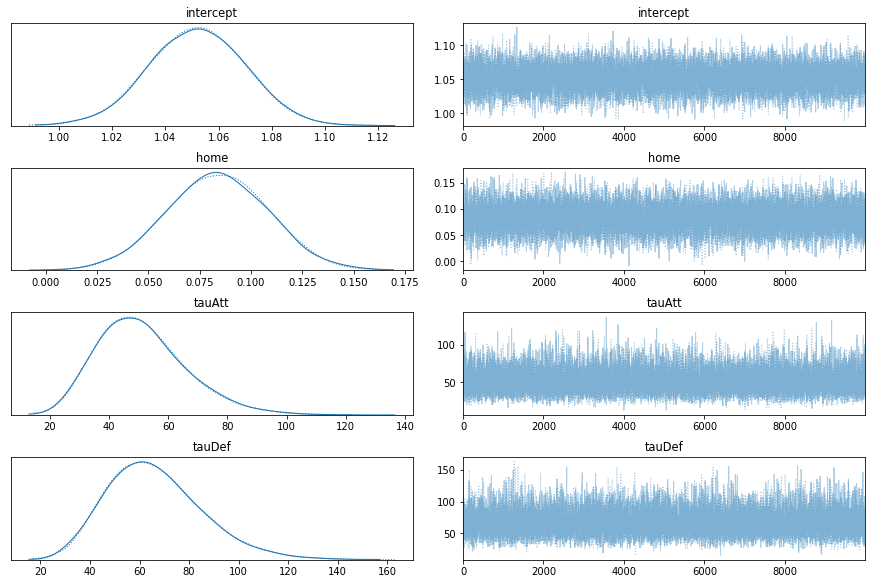

In [19]:
pm.traceplot(trace, var_names=['intercept', 'home', 'tauAtt', 'tauDef']);

In [20]:
bfmi = np.max(pm.stats.bfmi(trace))
maxGR = max(np.max(gr) for gr in pm.stats.rhat(trace).values()).values

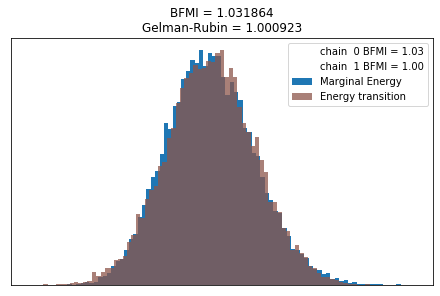

In [21]:
ax = pm.energyplot(trace, kind="histogram", legend=True, figsize=(6, 4))
ax.set_title("BFMI = %lf\nGelman-Rubin = %lf" % (bfmi, maxGR));

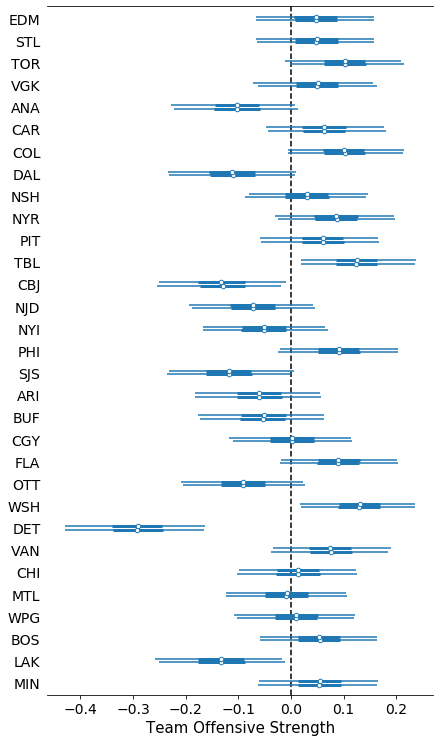

In [22]:
ax = pm.forestplot(trace, var_names=['atts'])
ax[0].set_yticklabels(teams.iloc[::-1]['name'].tolist())
ax[0].axvline(0, color="k", zorder=0, ls="--")
ax[0].set_xlabel('Team Offensive Strength', fontsize=15)
ax[0].set_title("");

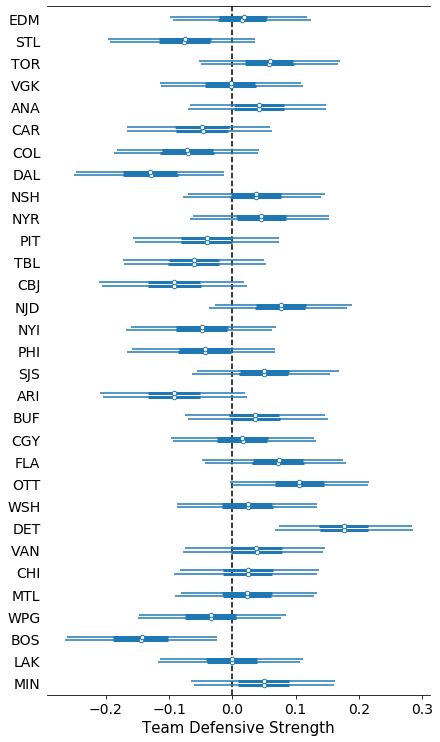

In [23]:
ax = pm.forestplot(trace, var_names=['defs'])
ax[0].axvline(0, color="k", zorder=0, ls="--")
ax[0].set_yticklabels(teams.iloc[::-1]['name'].tolist())
ax[0].set_xlabel('Team Defensive Strength', fontsize=15)
ax[0].set_title("");

In [24]:
# Sample from posterior predictive distribution
pp_trace = pm.sample_posterior_predictive(trace, samples=1000, model=model)

/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 335.57it/s]
